# Load all the imports! 

In [1]:
import collections
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf

from imgaug import augmenters as iaa
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
from keras.models import Sequential
from skimage import filters
from skimage import measure
from tensorflow.keras import datasets
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


#Dataset

In [0]:
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()

In [0]:
def sometimes(aug): return iaa.Sometimes(0.5, aug)
 
seq = iaa.Sequential([
    iaa.Affine(
        scale={"x": (0.8, 1), "y": (0.8, 1)},
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        rotate=(-15, 15),
        shear=(-5, 5),
        cval=(0, 0),
        mode='constant'
    )
])

def crop_number(number):
    """
        Crops a MNIST digit to its containing bounding box with some random noise.
    """
    vsum = np.sum(number, axis=0)
    vsum[vsum > 0] = 1
    vdif = np.diff(vsum)
    vdif[vdif > 0] = 1
    xs = np.argwhere(vdif > 0).ravel()
 
    random_cut1 = np.random.randint(-1, 3)
    random_cut2 = np.random.randint(-1, 3)
 
    try:
        cropped_number = number[0:28, xs[0] - random_cut1:xs[1] + random_cut2]
        if cropped_number.shape[1] < 6:
            raise Exception
    except:
        cropped_number = number
 
    return cropped_number
 
def pad_image(number, target_shape=(28, 84)):
    """
        Makes all images the same shape
    """
    _shape = number.shape
 
    height_pad = (-_shape[0] + target_shape[0]) // 2
    width_pad = (-_shape[1] + target_shape[1]) // 2
 
    padded = cv2.copyMakeBorder(number,
                                height_pad,
                                height_pad,
                                width_pad + int(_shape[1] % 2 == 1),
                                width_pad,
                                cv2.BORDER_CONSTANT,
                                value=0)
    return padded
 
 
def generate_images(data_x, data_y, batch_size, length=255):
    """
        Generates images containing numbers from MNIST with random translations.
    """
 
    while True:
 
        x_batch = []
        y_numbers_batch = []
        y_results = []
 
        for _ in range(batch_size):
            x = [np.zeros((28, 0)), np.zeros((28, 0))]
            y_numbers = []
 
            for num in range(2):
                random_num = random.randrange(length)
                decimal = str(random_num)
 
                y_numbers.append(np.array([random_num]))
 
                for digit in decimal:
                    numbers = np.argwhere(data_y == int(digit))
 
                    loc = np.random.choice(numbers.ravel(), 1)
                    number = np.squeeze(data_x[loc])
                    augmented_number = seq.augment_images([number])[0]
                    cropped_number = crop_number(augmented_number)
 
                    x[num] = np.hstack((x[num], cropped_number))
                x[num] = pad_image(x[num])
 
            x_batch.append(x)
            y_numbers_batch.append(y_numbers)
            y_results.append(y_numbers[-1] + y_numbers[-2])
 
        yield np.array(x_batch), np.squeeze(np.array(y_numbers_batch)), np.array(y_results)
 
 
def training_generator(batch_size=32):
    """
        Use this function to generate training samples. Images are generated using the training set of MNIST.
        Example usage:
 
        generator = training_generator(batch_size=8) # batch size of 8
 
        x, numbers, numbers_sum = next(generator)
 
        # x.shape == (8, 2, 28, 84)     # 8 pairs of images with height 28px and width 84px
        # numbers.shape == (8, 2)       # 8 pairs of numbers corresponding to the images
        # numbers_sum.shape == (8, 1)   # 8 numbers that represent the sum of the numbers from the images
 
    """
    return generate_images(x_train, y_train, batch_size)
 
 
def test_generator(batch_size=32):
    """
        Use this function to generate test samples. Images are generated using the test set of MNIST.
        Example usage:
 
        generator = test_generator(batch_size=8) # batch size of 8
 
        x, numbers, numbers_sum = next(generator)
 
        # x.shape == (8, 2, 28, 84)     # 8 pairs of images with height 28px and width 84px
        # numbers.shape == (8, 2)       # 8 pairs of numbers corresponding to the images
        # numbers_sum.shape == (8, 1)   # 8 numbers that represent the sum of the numbers from the images
 
    """
    return generate_images(x_test, y_test, batch_size)

In [0]:
generator = training_generator(batch_size = 256);

x, numbers, numbers_sum = next(generator);

# Task 1: Image Classification


Pentru aceasta prima cerinta am decis sa testez atat varianta in care pastrez imaginile complete, fara a separa cifrele, dar si varianta in care separ cifrele fiecarei imagini, adaptand de asemenea labelul . Astfel fiecare cifra a unei imagini va avea un label corespunzator. 


## Imagini in care cifrele nu sunt separate

In [0]:
X_train_cls = []
y_train_cls = []

Generez setul de date de antrenare alcatuit din 50 de batch-uri a cate 256 de perechi, iar pentru fiecare batch in parte consider ambele numere ale perechi drept exemplu separat pentru antrenare. 
La fel si pentru label-urile fiecarei perechi. 

In [0]:
for i in range (0,50):
  x, numbers, numbers_sum = next(generator);
  for j in range(0,256):
    X_train_cls.append(x[j, 0])
    X_train_cls.append(x[j, 1])
    y_train_cls.append(numbers[j, 0])
    y_train_cls.append(numbers[j, 1])

Plotez numarul de exemple al fiecarei categorii si observam ca s-au generat in medie 100 de exemple pentru fiecare numar intre 0 si 254.

Counter({59: 130, 221: 123, 215: 121, 152: 121, 67: 121, 84: 119, 140: 119, 188: 119, 249: 118, 96: 118, 126: 117, 161: 117, 230: 117, 54: 117, 109: 117, 56: 117, 21: 116, 236: 116, 5: 115, 29: 115, 2: 115, 34: 114, 226: 114, 26: 114, 47: 114, 160: 114, 62: 114, 55: 114, 229: 114, 254: 114, 110: 113, 6: 113, 69: 113, 57: 113, 138: 112, 175: 112, 13: 112, 11: 112, 158: 111, 209: 111, 119: 111, 17: 111, 195: 111, 87: 110, 202: 110, 52: 110, 82: 110, 244: 110, 33: 110, 232: 109, 76: 109, 248: 108, 39: 108, 94: 108, 15: 108, 156: 108, 192: 107, 3: 107, 53: 107, 155: 107, 148: 107, 63: 107, 101: 107, 19: 107, 165: 107, 44: 107, 218: 107, 170: 106, 127: 106, 180: 106, 219: 106, 0: 106, 224: 106, 72: 106, 186: 106, 199: 106, 45: 105, 228: 105, 201: 105, 128: 105, 123: 105, 10: 105, 121: 105, 169: 105, 75: 105, 108: 105, 95: 104, 115: 104, 114: 104, 7: 104, 149: 104, 178: 104, 40: 104, 8: 104, 124: 104, 16: 103, 37: 103, 131: 103, 227: 103, 196: 103, 206: 103, 197: 102, 93: 102, 100: 102, 28: 

<Container object of 255 artists>

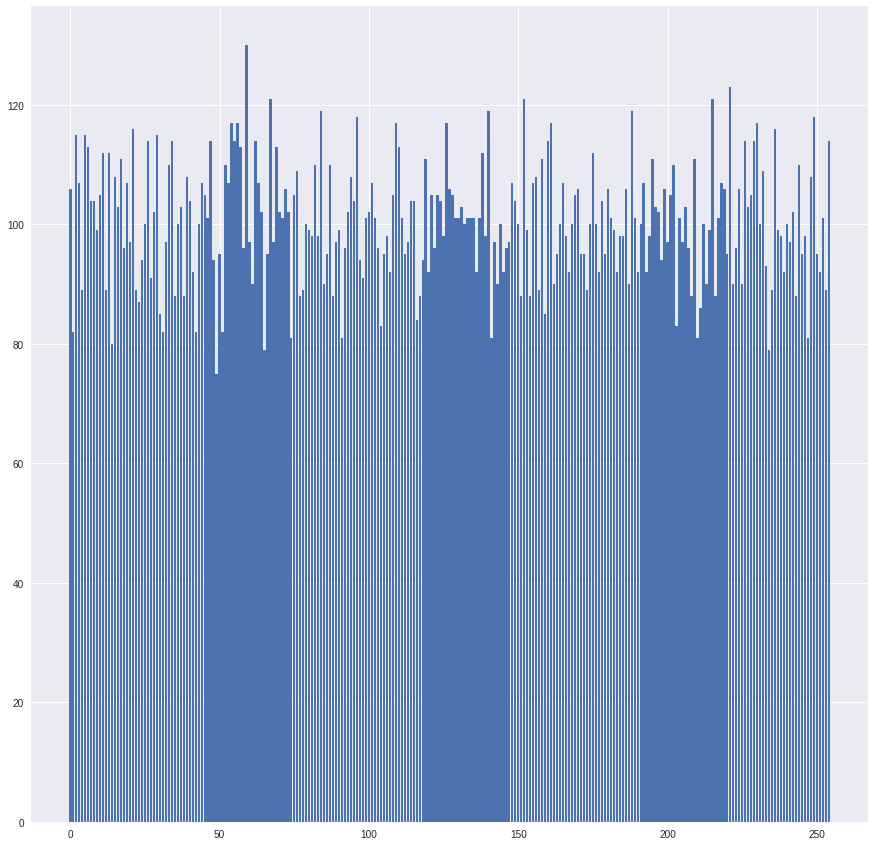

In [7]:
import collections

counter=collections.Counter(y_train_cls)
print (counter)

plt.figure(figsize=(15,15))
plt.bar(counter.keys(), counter.values())

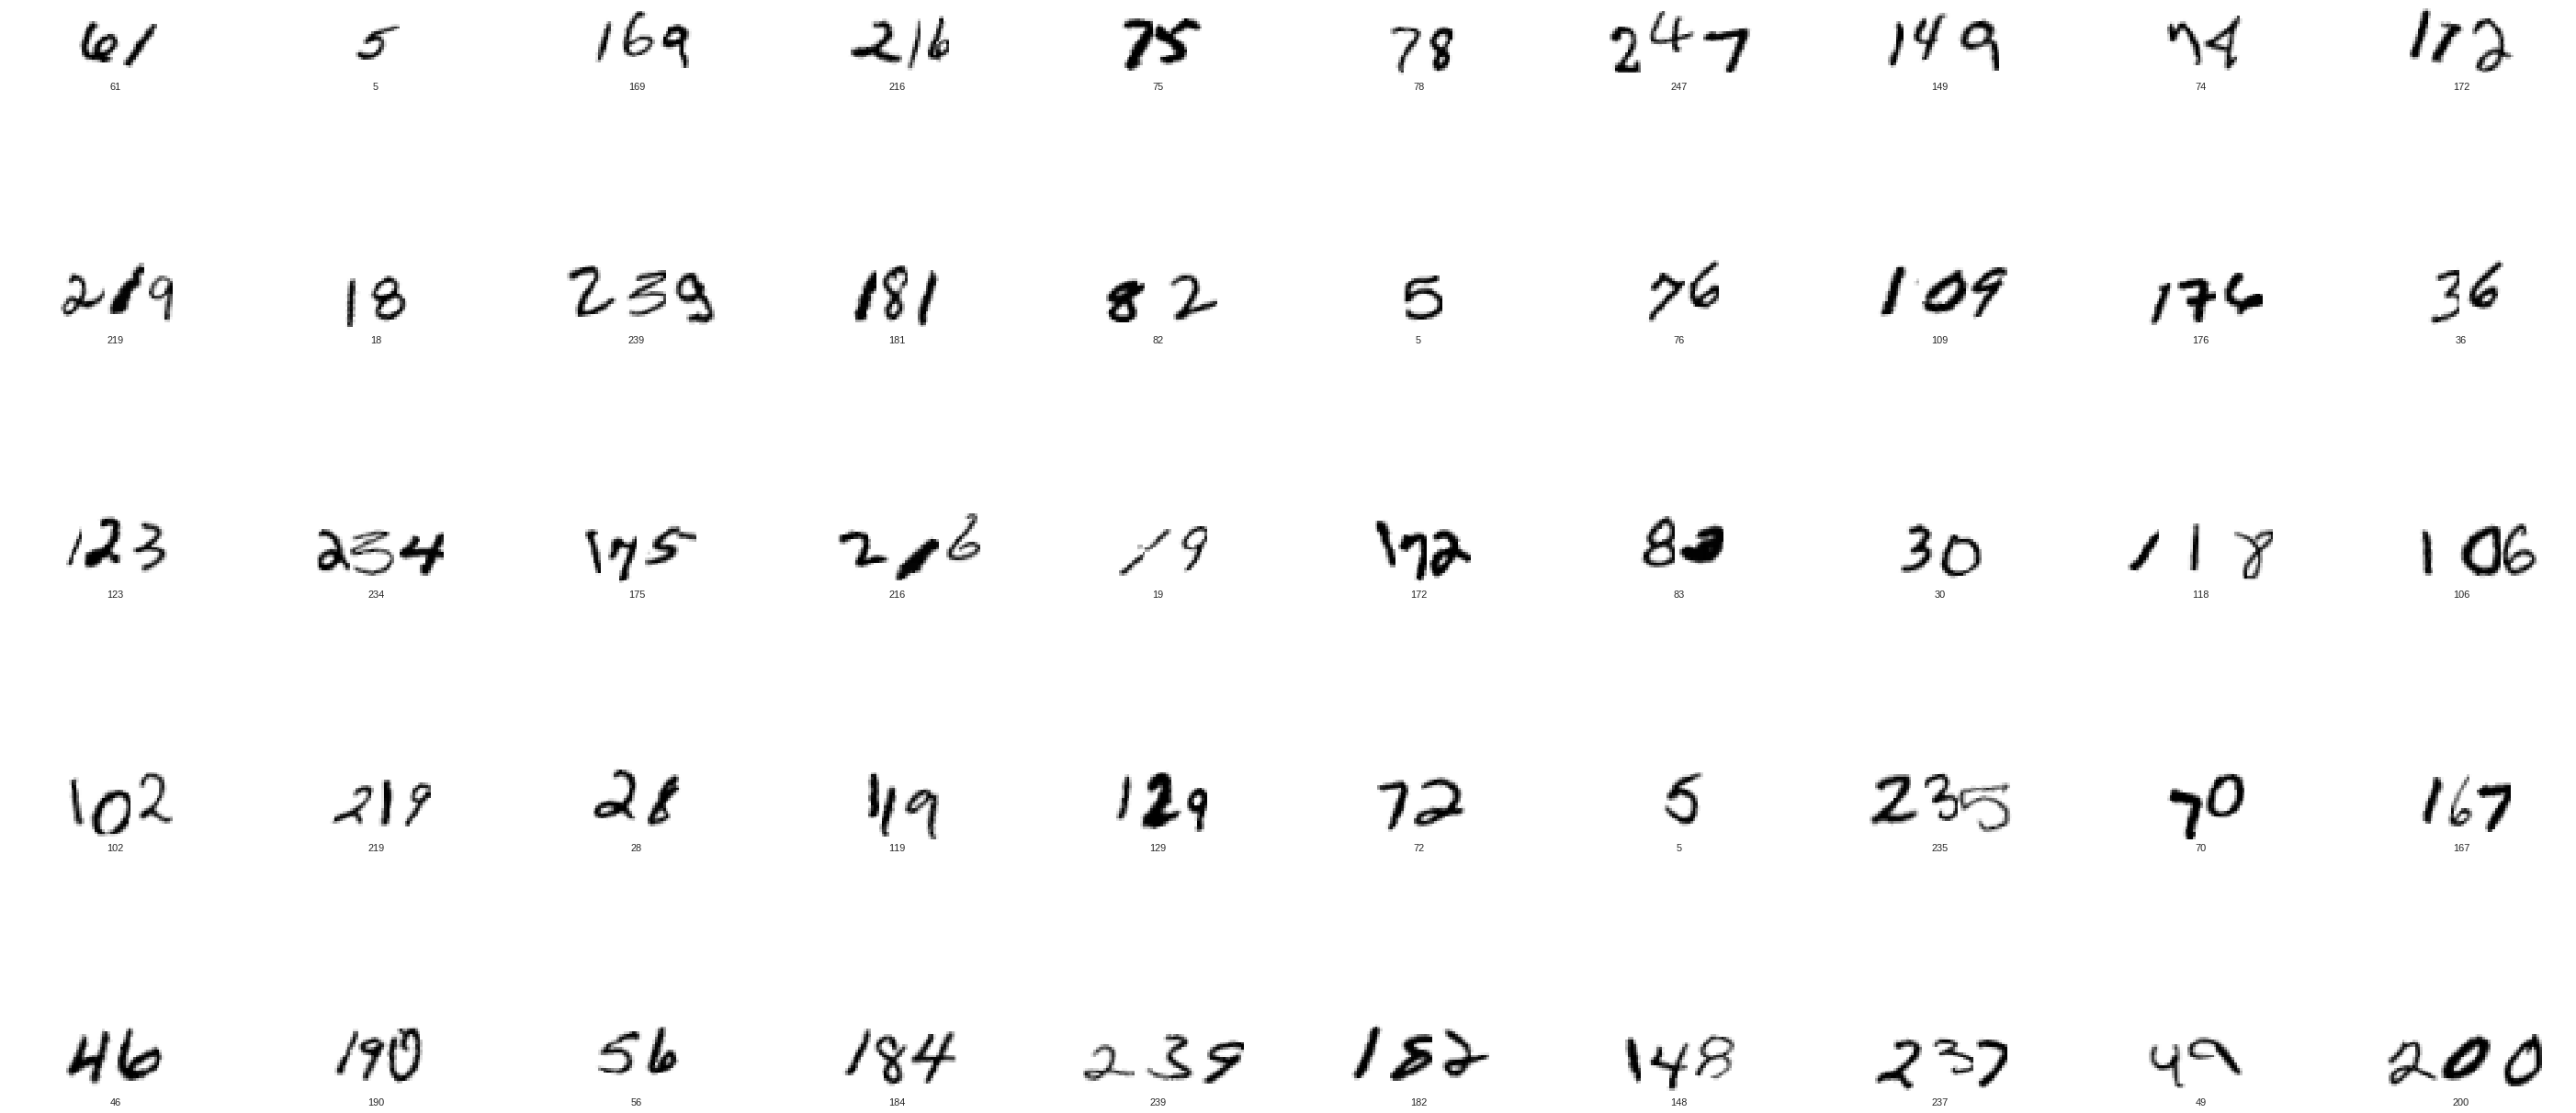

In [0]:
plt.figure(figsize=(50,50))
for i in range(50):
    plt.subplot(10,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train_cls[i], cmap=plt.cm.binary)
    plt.xlabel(y_train_cls[i])


Antrenez doua modele: un multilayer perceptron ce primeste imagini de 28x84 si determina careia dintre cele 255 de clase ii corespunde, si un CNN cu doua straturi convolutionale si un strat de iesire asemeni celui din primul model.

### MLP

In [0]:
X_train_cls_array = np.array(X_train_cls)
y_train_cls_array = np.array(y_train_cls)

In [9]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape = np.array(X_train_cls_array).shape[1:]), #the first layer always need the input_shape param
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(255, activation='softmax')
])
model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 2352)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               235300    
_________________________________________________________________
dense_1 (Dense)              (None, 255)               25755     
Total params: 261,055
Trainable params: 261,055
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.fit(X_train_cls_array, y_train_cls_array, epochs=15)

Epoch 1/15
25600/25600 [==============================] - 4s 140us/step - loss: 16.0166 - acc: 0.0062
Epoch 2/15
25600/25600 [==============================] - 3s 124us/step - loss: 15.9760 - acc: 0.0087
Epoch 3/15
25600/25600 [==============================] - 3s 123us/step - loss: 15.9536 - acc: 0.0100
Epoch 4/15
25600/25600 [==============================] - 3s 115us/step - loss: 15.9578 - acc: 0.0099
Epoch 5/15
25600/25600 [==============================] - 3s 116us/step - loss: 15.9578 - acc: 0.0099
Epoch 6/15
25600/25600 [==============================] - 3s 117us/step - loss: 15.9578 - acc: 0.0099
Epoch 7/15
25600/25600 [==============================] - 3s 119us/step - loss: 15.9578 - acc: 0.0099
Epoch 8/15
25600/25600 [==============================] - 3s 125us/step - loss: 15.9578 - acc: 0.0099
Epoch 9/15
25600/25600 [==============================] - 3s 116us/step - loss: 15.9578 - acc: 0.0099
Epoch 10/15
25600/25600 [==============================] - 3s 116us/step - loss: 1

### CNN

In [0]:
X_train_cls_array = np.expand_dims(X_train_cls_array, -1)

In [12]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(input_shape=X_train_cls_array.shape[1:], kernel_size=(3,3), filters=20, activation='relu'))
model.add(tf.keras.layers.Conv2D(kernel_size=(3,3), filters=40, activation='relu'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(255, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 82, 20)        200       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 80, 40)        7240      
_________________________________________________________________
flatten_1 (Flatten)          (None, 76800)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 255)               19584255  
Total params: 19,591,695
Trainable params: 19,591,695
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.fit(X_train_cls_array, y_train_cls_array, epochs=15)

Epoch 1/15
25600/25600 [==============================] - 28s 1ms/step - loss: 16.0338 - acc: 0.0052
Epoch 2/15
25600/25600 [==============================] - 26s 1ms/step - loss: 16.0552 - acc: 0.0039
Epoch 3/15
25600/25600 [==============================] - 26s 1ms/step - loss: 16.0552 - acc: 0.0039
Epoch 4/15
25600/25600 [==============================] - 26s 1ms/step - loss: 16.0552 - acc: 0.0039
Epoch 5/15
25600/25600 [==============================] - 26s 1ms/step - loss: 16.0552 - acc: 0.0039
Epoch 6/15
25600/25600 [==============================] - 26s 1ms/step - loss: 16.0552 - acc: 0.0039
Epoch 7/15
25600/25600 [==============================] - 26s 1ms/step - loss: 16.0552 - acc: 0.0039
Epoch 8/15
25600/25600 [==============================] - 26s 1ms/step - loss: 16.0552 - acc: 0.0039
Epoch 9/15
25600/25600 [==============================] - 26s 1ms/step - loss: 16.0552 - acc: 0.0039
Epoch 10/15
25600/25600 [==============================] - 26s 1ms/step - loss: 16.0552 - a

Date fiind rezultatele pentru cele doua modele pe setul de antrenare (accuracy 0.0045 cu MLP si 0.0034 cu CNN) am decis sa nu mai continui cu un set de test.  

## Imagini in care separ cifrele 

* Pentru aceasta varianta am creat o functie ce primeste o imagine si labelul corespunzator.
* Imaginea o separa atribuind fiecarei forme din imagine cate o clasa (o valoare mai mare ca 0), iar pixelilor din background valoarea 0. Dupa care, pentru fiecare valoare distincta din imagine filtram restul valorilor pastrand astfel doar background-ul si valoarea respectiva reusind sa alcatuim cate o imagine de 28x84 pentru fiecare cifra. 
* Deoarece formele din imagine sunt adnotate de sus in jos si nu de la stanga la dreapta, imaginile nu vor corespunde in ordine cu cifrele din label asa ca pentru fiecare imagine reiesita cautam cel mai din stanga pixel, iar in functie de aceasta valoare atribuim o cifra din label. 
* De asemenea, tinem cont daca numarul de imagini reiesite este egal cu numarul de cifre al labelului. Daca acestea difera, nu vom lua in considerare acel exemplu. 

In [0]:
def separaCifre(im, label):
  
  im = filters.gaussian_filter(im, sigma= 0.1)
  blobs = im > 0.7 * im.mean()

  allLabels = measure.label(blobs)
  
  uniqueLabels = np.unique(allLabels)
  
  if (uniqueLabels.size - 1 == len(str(label))):
    imageArray = []
    for digit in uniqueLabels[1:]: 
      imageDigit = np.where(allLabels == digit, 1, 0)
      imageArray.append(imageDigit)
  
    dictDigits = {}
    for i in range(0, len(imageArray)):
      poz = np.count_nonzero(imageArray[i], axis=0)
      firstNonZero = next((i for i, x in enumerate(poz) if x), None)
      dictDigits[firstNonZero] = i
      
    orderedDict = collections.OrderedDict(sorted(dictDigits.items()))  
    digitsArray = np.zeros(uniqueLabels.size -1)
    index = 0;
    for (k,v) in orderedDict.items(): 
      digitsArray[v] = int(str(label)[index])
      index = index + 1
    
    return (imageArray, digitsArray);  
  return ([], [])


Generam asemanator setul de antrenare si cel de testare. Cel de antrenare este alcatuit din 50 de batch-uri a cate 256 de exemple, iar cel de test este alcatuit din 5 batch-uri a cate 256 exemple.  

In [0]:
X_train_cls = []
y_train_cls = []

In [0]:
for i in range (0,50):
  x, numbers, numbers_sum = next(generator);
  for j in range(0,256):
    X_train_cls.append(x[j, 0])
    X_train_cls.append(x[j, 1])
    y_train_cls.append(numbers[j, 0])
    y_train_cls.append(numbers[j, 1])

In [0]:
X_test_cls = [] 
y_test_cls = []

In [0]:
for i in range (0,5):
  x, numbers, numbers_sum = next(generator);
  for j in range(0,256):
    X_test_cls.append(x[j, 0])
    X_test_cls.append(x[j, 1])
    y_test_cls.append(numbers[j, 0])
    y_test_cls.append(numbers[j, 1])

In [19]:
print (len(X_train_cls))

25600


In [20]:
print (len(X_test_cls))

2560


* Pentru setul de antrenare si pentru setul de test vom forma un nou vector in care vom stoca cifrele separate si labelurile fiecarei cifre in parte doar pentru exemplele valide. 

* De asemenea, vom forma si un vector nou pentru setul de testare cu labelurile initiale (numere complete), dar doar pentru exemplele ce au putut fi impartite corect in cifre si vor fi mai tarziu evaluate de model.

In [0]:
X_train_separat = np.zeros((100000, 28, 84))
y_train_separat = np.zeros(100000)

In [22]:
index = 0
for i in range (0,len(X_train_cls)):
  (vectorCifre, vectorLabels) = separaCifre(X_train_cls[i], y_train_cls[i])
  if (len(vectorCifre) > 0): 
    for j in range(0, len(vectorCifre)):
      X_train_separat[index] = vectorCifre[j]
      y_train_separat[index] = int(vectorLabels[j])
      index = index + 1

/usr/local/lib/python3.6/dist-packages/skimage/filters/_gaussian.py:22: skimage_deprecation: Function ``gaussian_filter`` is deprecated. Use ``skimage.filters.gaussian`` instead.
  multichannel=None, preserve_range=False, truncate=4.0):
/usr/local/lib/python3.6/dist-packages/skimage/filters/_gaussian.py:22: skimage_deprecation: Function ``gaussian_filter`` is deprecated. Use ``skimage.filters.gaussian`` instead.
  multichannel=None, preserve_range=False, truncate=4.0):
/usr/local/lib/python3.6/dist-packages/skimage/filters/_gaussian.py:22: skimage_deprecation: Function ``gaussian_filter`` is deprecated. Use ``skimage.filters.gaussian`` instead.
  multichannel=None, preserve_range=False, truncate=4.0):
/usr/local/lib/python3.6/dist-packages/skimage/filters/_gaussian.py:22: skimage_deprecation: Function ``gaussian_filter`` is deprecated. Use ``skimage.filters.gaussian`` instead.
  multichannel=None, preserve_range=False, truncate=4.0):
/usr/local/lib/python3.6/dist-packages/skimage/filte

In [0]:
X_train_separat = X_train_separat[:index]
y_train_separat = y_train_separat[:index]

In [0]:
X_test_separat = np.zeros((100000, 28, 84))
y_test_separat = np.zeros(100000)
y_test_neseparat = np.zeros(100000)

In [25]:
index = 0
indexExempleValide = 0
for i in range (0,len(X_test_cls)):
  (vectorCifre, vectorLabels) = separaCifre(X_test_cls[i], y_test_cls[i])
  if (len(vectorCifre) > 0): 
    for j in range(0, len(vectorCifre)):
      X_test_separat[index] = vectorCifre[j]
      y_test_separat[index] = int(vectorLabels[j])
      index = index + 1
    y_test_neseparat[indexExempleValide] = y_test_cls[i]  
    indexExempleValide = indexExempleValide + 1

/usr/local/lib/python3.6/dist-packages/skimage/filters/_gaussian.py:22: skimage_deprecation: Function ``gaussian_filter`` is deprecated. Use ``skimage.filters.gaussian`` instead.
  multichannel=None, preserve_range=False, truncate=4.0):
/usr/local/lib/python3.6/dist-packages/skimage/filters/_gaussian.py:22: skimage_deprecation: Function ``gaussian_filter`` is deprecated. Use ``skimage.filters.gaussian`` instead.
  multichannel=None, preserve_range=False, truncate=4.0):
/usr/local/lib/python3.6/dist-packages/skimage/filters/_gaussian.py:22: skimage_deprecation: Function ``gaussian_filter`` is deprecated. Use ``skimage.filters.gaussian`` instead.
  multichannel=None, preserve_range=False, truncate=4.0):
/usr/local/lib/python3.6/dist-packages/skimage/filters/_gaussian.py:22: skimage_deprecation: Function ``gaussian_filter`` is deprecated. Use ``skimage.filters.gaussian`` instead.
  multichannel=None, preserve_range=False, truncate=4.0):
/usr/local/lib/python3.6/dist-packages/skimage/filte

In [0]:
X_test_separat = X_test_separat[:index]
y_test_separat = y_test_separat[:index]
y_test_neseparat = y_test_neseparat[:indexExempleValide]

### MLP

In [27]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape = np.array(X_train_separat).shape[1:]), #the first layer always need the input_shape param
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(255, activation='softmax')
])
model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 2352)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               235300    
_________________________________________________________________
dense_4 (Dense)              (None, 255)               25755     
Total params: 261,055
Trainable params: 261,055
Non-trainable params: 0
_________________________________________________________________


In [28]:
model.fit(X_train_separat, y_train_separat, epochs=15)

Epoch 1/15
55927/55927 [==============================] - 10s 175us/step - loss: 1.9454 - acc: 0.4244
Epoch 2/15
55927/55927 [==============================] - 11s 192us/step - loss: 1.3442 - acc: 0.5672
Epoch 3/15
55927/55927 [==============================] - 10s 176us/step - loss: 1.1933 - acc: 0.6096
Epoch 4/15
55927/55927 [==============================] - 10s 174us/step - loss: 1.0932 - acc: 0.6456
Epoch 5/15
55927/55927 [==============================] - 10s 175us/step - loss: 1.0056 - acc: 0.6788
Epoch 6/15
55927/55927 [==============================] - 10s 177us/step - loss: 0.9238 - acc: 0.7115
Epoch 7/15
55927/55927 [==============================] - 10s 182us/step - loss: 0.8469 - acc: 0.7362
Epoch 8/15
55927/55927 [==============================] - 10s 180us/step - loss: 0.7776 - acc: 0.7609
Epoch 9/15
55927/55927 [==============================] - 10s 182us/step - loss: 0.7156 - acc: 0.7819
Epoch 10/15
55927/55927 [==============================] - 10s 182us/step - loss: 

In [29]:
model.evaluate(X_test_separat, y_test_separat)

5601/5601 [==============================] - 1s 156us/step


[0.5578989371154547, 0.8286020353508302]

### CNN

In [0]:
X_train_separat = np.expand_dims(X_train_separat, -1)
X_test_separat = np.expand_dims(X_test_separat, -1)

In [31]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), input_shape = (28,84,1), activation='relu', padding='same'))
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), input_shape = (28,84,32), activation='relu', padding='same'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(10, activation='softmax'))
model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 84, 32)        320       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 84, 32)        9248      
_________________________________________________________________
flatten_3 (Flatten)          (None, 75264)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                752650    
Total params: 762,218
Trainable params: 762,218
Non-trainable params: 0
_________________________________________________________________


In [32]:
model.fit(X_train_separat, y_train_separat, epochs=15)

Epoch 1/15
55927/55927 [==============================] - 21s 383us/step - loss: 1.3410 - acc: 0.5394
Epoch 2/15
55927/55927 [==============================] - 17s 303us/step - loss: 0.8427 - acc: 0.7340
Epoch 3/15
55927/55927 [==============================] - 16s 295us/step - loss: 0.5885 - acc: 0.8206
Epoch 4/15
55927/55927 [==============================] - 16s 294us/step - loss: 0.4928 - acc: 0.8491
Epoch 5/15
55927/55927 [==============================] - 16s 294us/step - loss: 0.4335 - acc: 0.8690
Epoch 6/15
55927/55927 [==============================] - 17s 296us/step - loss: 0.3890 - acc: 0.8824
Epoch 7/15
55927/55927 [==============================] - 17s 299us/step - loss: 0.3527 - acc: 0.8946
Epoch 8/15
55927/55927 [==============================] - 16s 295us/step - loss: 0.3219 - acc: 0.9024
Epoch 9/15
55927/55927 [==============================] - 16s 294us/step - loss: 0.2951 - acc: 0.9116
Epoch 10/15
55927/55927 [==============================] - 16s 294us/step - loss: 

In [33]:
model.evaluate(X_test_separat, y_test_separat)

5601/5601 [==============================] - 1s 152us/step


[0.3803782495211925, 0.8878771647920014]

Model imbunatati cu pooling si dropout! 

In [34]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), input_shape = (28,84,1), activation='relu', padding='same'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), input_shape = (14,14,32), activation='relu', padding='same'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), input_shape = (7,7,32), activation='relu', padding='same'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(10, activation='softmax'))
model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 84, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 42, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 42, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 42, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 21, 64)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 21, 64)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 21, 64)         36928     
__________

In [35]:
model.fit(X_train_separat, y_train_separat, epochs=10)
model.evaluate(X_test_separat, y_test_separat)

Epoch 1/10
55927/55927 [==============================] - 23s 407us/step - loss: 1.5313 - acc: 0.4601
Epoch 2/10
55927/55927 [==============================] - 21s 381us/step - loss: 0.7902 - acc: 0.7429
Epoch 3/10
55927/55927 [==============================] - 22s 386us/step - loss: 0.5056 - acc: 0.8412
Epoch 4/10
55927/55927 [==============================] - 25s 454us/step - loss: 0.4038 - acc: 0.8737
Epoch 5/10
55927/55927 [==============================] - 25s 455us/step - loss: 0.3473 - acc: 0.8911
Epoch 6/10
55927/55927 [==============================] - 25s 453us/step - loss: 0.3075 - acc: 0.9044
Epoch 7/10
55927/55927 [==============================] - 25s 453us/step - loss: 0.2779 - acc: 0.9147
Epoch 8/10
55927/55927 [==============================] - 25s 448us/step - loss: 0.2555 - acc: 0.9213
Epoch 9/10
55927/55927 [==============================] - 25s 453us/step - loss: 0.2376 - acc: 0.9263
Epoch 10/10
5601/5601 [==============================] - 1s 220us/step


[0.17987626424124786, 0.9462595965006249]

Acesta din urma a obtinut cele mai bune rezultate atat pe setul de antrenare, cat si pe cel de testare asa ca il vom folosi si pentru a verifica acuratetea modelului in prezicerea labelurilor neseparate.

In [0]:
model.save('CNN_num_model.h5')

In [0]:
clasePrezise = model.predict_classes(X_test_separat)

Pentru fiecare exemplu neseparat vom lua multimea cifrelor sale si o vom compara cu multimea echivalenta (de acelasi cardinal) din vectorul de clase prezise. 

In [0]:
exempleCorecte = 0
exempleTotal = len(y_test_neseparat)

index = 0
for i in range(0, len(y_test_neseparat)):
  lenNumar = len(str(int(y_test_neseparat[i])))
  yAdevarat = []
  for j in range(0, lenNumar):
    yAdevarat.append(int(str(y_test_neseparat[i])[j]))
  
  if (collections.Counter(clasePrezise[index:(index + lenNumar)]) == collections.Counter(yAdevarat)):
    exempleCorecte = exempleCorecte + 1
  index = index + lenNumar   

In [39]:
print (exempleCorecte)
print (exempleTotal)

accuracyNumere = str(exempleCorecte / exempleTotal)
print ("Acuratetea pentru prezicerea numerelor: " + accuracyNumere)

1926
2212
Acuratetea pentru prezicerea numerelor: 0.8707052441229657


# Task 2: Addition

* Pentru cel de-al doilea task am avut de construit o retea recurenta neuronala ce primeste de la intrare doua numere si vrea sa prezinca suma lor. 
* Am construit o functie ce genereaza un numar dat de perechi a caror lungime maxima este de asemenea precizata. Pentru fiecare pereche calculam suma, iar pe urma codificam perechea astfel: fiecarui numar ii corespund lungime_maxima_numar + 1 linii, de cate 10 elemente (fiecare element corespunde unei cifre intre 0 si 9). Fiecare linie este alcatuita din zero, mai putin o pozitie unde se afla 1 - pe acea pozitie avem o cifra a numarului codificat.  Spre exemplu: numarul 028 va avea urmatoarea reprezentare: 

    [[1, 0,0,0,0,0,0,0,0,0] -- 1 pe pozitia 0
     
     [0,0,1,0,0,0,0,0,0,0], -- 1 pe pozitia 2
     
     [0,0,0,0,0,0,0,0,1,0]] -- 1 pe pozitia 8


* Asadar, un exemplu pentru retea va avea 2 * (lungime_maxima_numar + 1) linii si 10 coloane, iar un label al va avea (lungime_maxima_numar + 1) linii si 10 coloane. 

* Pe baza acesteia, vom genera setul de antrenare si setul de testare, dar vom returna de asemenea si numerele si suma inainte de codificare. 

In [0]:
def gen_sequence_data(n = 10000,max_lenght = 2):
  X = np.zeros((n, (max_lenght+1)*2, 10))
  Y = np.zeros((n, max_lenght+1, 10))
  trueLabels = np.zeros(n)
  xTrueNumbers = np.zeros((n,2))
  for i in range(n):
    a = np.random.randint(10**max_lenght)
    b = np.random.randint(10**max_lenght)
    s = a + b
    '''print (a) 
    print (b)
    print (s)'''
    trueLabels[i] = s;
    xTrueNumbers[i,0] = a;
    xTrueNumbers[i,1] = b;
    a = [int(i) for i in str(a)]
    b = [int(i) for i in str(b)]
    s = [int(i) for i in str(s)]
    a,b,s = pad_sequences([a,b,s],maxlen = max_lenght + 1)
    '''print (a) 
    print (b)
    print (s)'''
    x , y = np.concatenate([a,b]) , s
    for j, char in enumerate(x):
         X[i, j, char] = 1

    for j, char in enumerate(s):
         Y[i, j, char] = 1
  return X, Y, xTrueNumbers, trueLabels

Exemplu numere inainte si dupa codificare. 

In [43]:
X_train_labels[1,:]

array([87., 63.])

In [44]:
X_train_seq[1]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])

In [0]:
(X_train_seq, y_train_seq, X_train_labels, y_train_labels) = gen_sequence_data();  

In [0]:
(X_test_seq, y_test_seq, X_test_labels, y_test_labels) = gen_sequence_data(1000);  

Folosind datele generate vom antrena un model cu doua layere LSTM, al carui rezultat va fi reprezentat printr-un vector de lungime_maxima_nr + 1 linii si 10 coloane. Totusi, pentru a prezice direct cifrele pentru setul de testare am folosit predict_classes ce intoarce un vector de lungime_maxima_nr + 1 elemente (in cazul dat lungime_maxima_nr = 3) 

In [46]:
model = Sequential()
model.add(LSTM(100, input_shape=(6,10)))
model.add(RepeatVector(3))
model.add(LSTM(50, return_sequences=True))
model.add(TimeDistributed(Dense(10, activation='softmax')))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               44400     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 3, 100)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 3, 50)             30200     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 3, 10)             510       
Total params: 75,110
Trainable params: 75,110
Non-trainable params: 0
_________________________________________________________________
None


In [47]:
model.fit(X_train_seq, y_train_seq, epochs=25)

Epoch 1/25
10000/10000 [==============================] - 10s 1ms/step - loss: 1.8093 - acc: 0.3069
Epoch 2/25
10000/10000 [==============================] - 9s 920us/step - loss: 1.6018 - acc: 0.3813
Epoch 3/25
10000/10000 [==============================] - 9s 933us/step - loss: 1.3366 - acc: 0.5087
Epoch 4/25
10000/10000 [==============================] - 9s 940us/step - loss: 1.1833 - acc: 0.5645
Epoch 5/25
10000/10000 [==============================] - 9s 939us/step - loss: 1.0974 - acc: 0.6082
Epoch 6/25
10000/10000 [==============================] - 9s 938us/step - loss: 1.0495 - acc: 0.6182
Epoch 7/25
10000/10000 [==============================] - 9s 934us/step - loss: 1.0022 - acc: 0.6427
Epoch 8/25
10000/10000 [==============================] - 9s 934us/step - loss: 0.9697 - acc: 0.6531
Epoch 9/25
10000/10000 [==============================] - 9s 941us/step - loss: 0.9439 - acc: 0.6627
Epoch 10/25
10000/10000 [==============================] - 9s 936us/step - loss: 0.9086 - ac

In [48]:
model.evaluate(X_test_seq, y_test_seq)

1000/1000 [==============================] - 1s 642us/step


[0.046332658171653746, 0.9936666603088379]

In [0]:
model.save('CNN_add_model.h5')

In [0]:
predictedValues = model.predict_classes(X_test_seq)

In [50]:
predictedValues

array([[0, 7, 7],
       [0, 4, 3],
       [0, 2, 6],
       ...,
       [1, 5, 6],
       [0, 8, 4],
       [1, 0, 8]])

In [51]:
y_test_labels

array([ 77.,  43.,  26.,  76.,  89., 149.,  20.,  31., 127.,  86., 150.,
       163.,  96., 152., 144.,  78.,  92., 118.,  91.,  40., 117.,  94.,
       110., 116., 158., 122.,  40.,  66.,  78., 105., 129.,  99., 117.,
        40., 122.,  73., 148., 100.,  45., 155.,  87.,  65., 113.,  53.,
       148., 112.,  57., 118.,  31.,  90., 134.,  99., 110.,  63.,  86.,
       136.,  55.,  86., 117., 155.,  66., 139.,  88.,  76.,  44.,  57.,
       145., 151., 122.,  78.,  85., 139.,  57., 131.,  86.,  30.,  45.,
        28., 122., 144.,  94.,  34.,  45., 136.,  20.,  34., 117., 158.,
       142., 103., 102.,  89.,  42., 177., 113.,  77., 107.,  50., 121.,
       106., 156.,  22., 110.,  56.,  92.,   9., 102.,  71., 123., 169.,
       127.,  33., 177., 154.,  16.,  57., 133.,  25., 121., 101., 169.,
       108., 154.,  77., 115., 185., 108., 149., 113.,  98., 108.,  43.,
       111., 116., 105., 103., 111., 111.,  40.,  56., 130., 101.,  79.,
       110.,  84., 130., 155., 144., 111., 142., 11

* decode_seq este folosita pentru a alcatui un numar pe baza vectorului de cifre prezis de model. 

In [0]:
def decode_seq(y_seq):

  length  = y_seq.shape[0]
  number = 0;
  for index in range(length):
    number = number * 10 + y_seq[index];
  return number;

In continuare am calculat mean squared error pentru multimea de test si am afisat cateva exemple sub forma "numar_1 + numar_2 = suma_prezisa / suma_adevarata".

In [0]:
errorSum = 0;
totalExamples = len(y_test_labels);

In [0]:
for index in range(len(y_test_labels)): 
  predictedNumber = decode_seq(predictedValues[index])
  errorSum = errorSum + (predictedNumber - y_test_labels[index])**2

In [56]:
print ("Mean squared error: " + str(errorSum / totalExamples))

Mean squared error: 1.9


In [57]:
print ("a + b = suma_prezisa / suma_adevarata")
for index in range(50):
  a = X_test_labels[index, 0];
  b = X_test_labels[index, 1];
  sPredicted = decode_seq(predictedValues[index]);
  s = y_test_labels[index];
  print (str(int(a)) + " + " + str(int(b)) + " = " + str(int(sPredicted)) + " / " + str(int(s)))

a + b = suma_prezisa / suma_adevarata
65 + 12 = 77 / 77
6 + 37 = 43 / 43
2 + 24 = 26 / 26
65 + 11 = 76 / 76
16 + 73 = 89 / 89
82 + 67 = 149 / 149
18 + 2 = 20 / 20
10 + 21 = 31 / 31
55 + 72 = 127 / 127
83 + 3 = 86 / 86
58 + 92 = 150 / 150
70 + 93 = 163 / 163
24 + 72 = 96 / 96
95 + 57 = 152 / 152
48 + 96 = 144 / 144
33 + 45 = 78 / 78
76 + 16 = 92 / 92
88 + 30 = 118 / 118
9 + 82 = 91 / 91
29 + 11 = 40 / 40
87 + 30 = 117 / 117
81 + 13 = 94 / 94
47 + 63 = 110 / 110
86 + 30 = 116 / 116
92 + 66 = 158 / 158
25 + 97 = 122 / 122
17 + 23 = 40 / 40
1 + 65 = 66 / 66
28 + 50 = 78 / 78
68 + 37 = 105 / 105
58 + 71 = 139 / 129
30 + 69 = 99 / 99
44 + 73 = 117 / 117
5 + 35 = 40 / 40
82 + 40 = 122 / 122
21 + 52 = 73 / 73
80 + 68 = 148 / 148
38 + 62 = 100 / 100
21 + 24 = 45 / 45
72 + 83 = 155 / 155
17 + 70 = 87 / 87
25 + 40 = 65 / 65
26 + 87 = 113 / 113
4 + 49 = 53 / 53
84 + 64 = 148 / 148
98 + 14 = 112 / 112
23 + 34 = 57 / 57
52 + 66 = 118 / 118
25 + 6 = 31 / 31
66 + 24 = 90 / 90
